## Encoder-Decoder Model

The encoder-decoder model is a way of using recurrent neural networks for sequence-to-sequence prediction problems.

It was initially developed for machine translation problems, although it has proven successful at related sequence-to-sequence prediction problems such as text summarization and question answering.

The approach involves two recurrent neural networks, one to encode the input sequence, called the encoder, and a second to decode the encoded input sequence into the target sequence called the decoder.

Following are some of the application of sequence to sequence models:-  
•Chatbots  
•Machine Translation  
•Text summary  
•Image captioning

### The architecture of Encoder-Decoder -

The overall structure of sequence to sequence model(encoder-decoder) which is commonly used is as shown below-
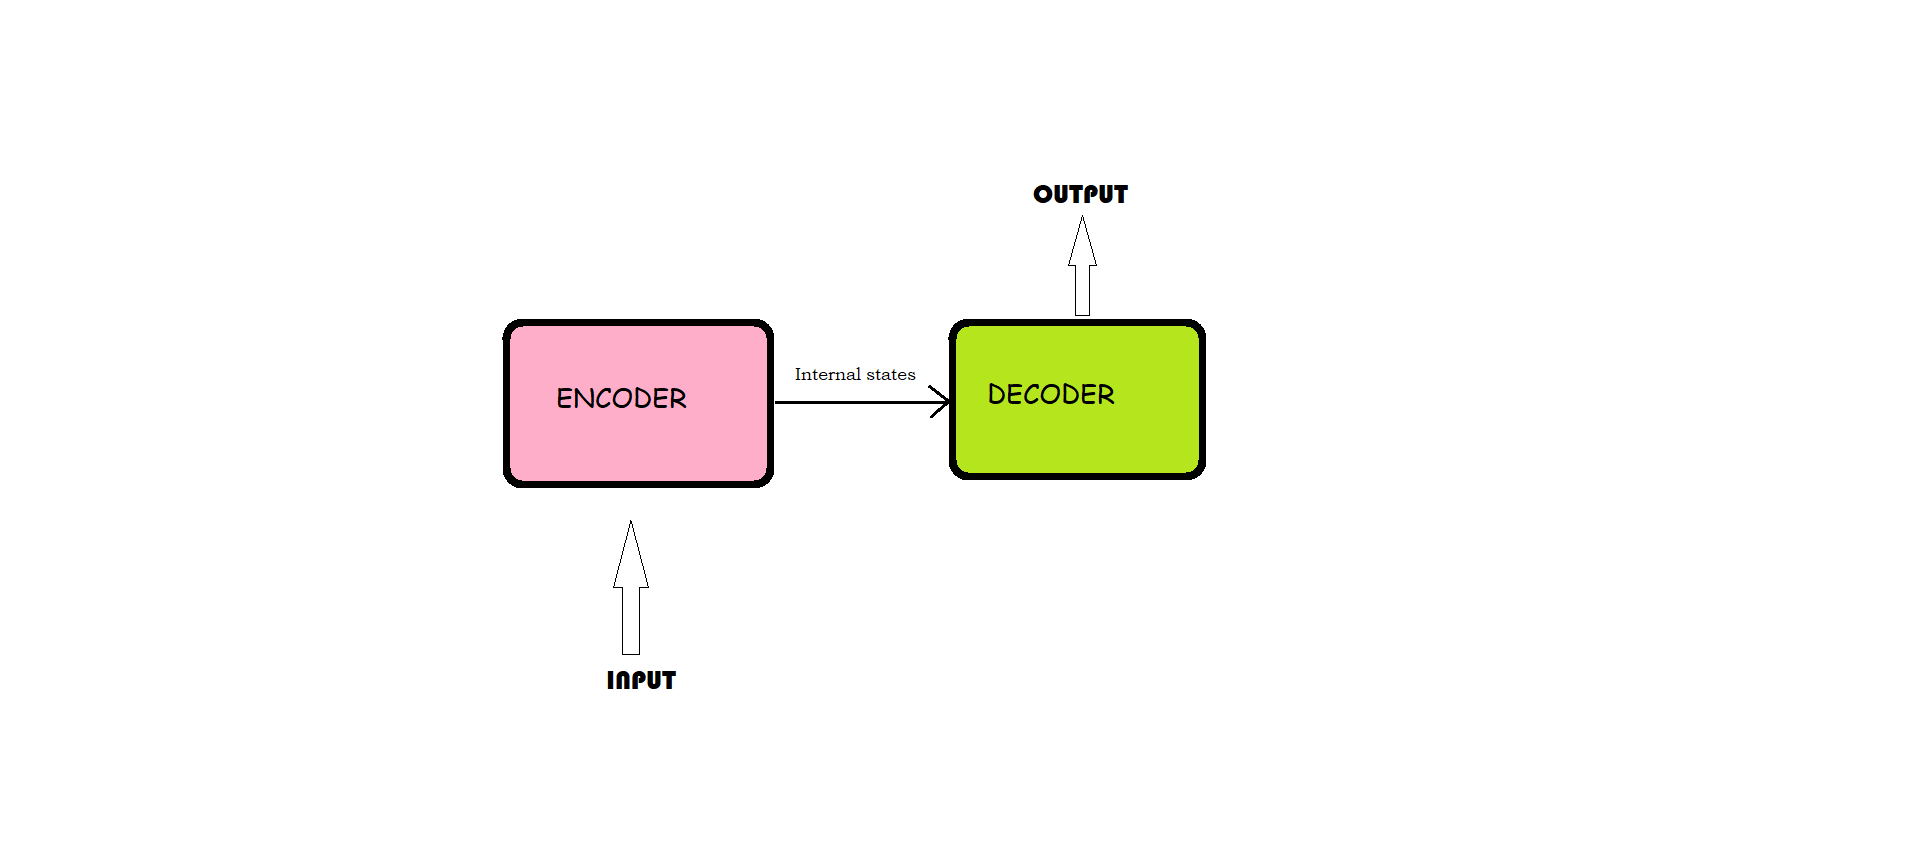
It consists of 3 parts: encoder, intermediate vector and decoder.

**Encoder**-It accepts a single element of the input sequence at each time step, process it, collects information for that element and propagates it forward.

**Intermediate vector**- This is the final internal state produced from the encoder part of the model. It contains information about the entire input sequence to help the decoder make accurate predictions.

**Decoder**- given the entire sentence, it predicts an output at each time step.

### Understanding the Encoder part of the model-
•The encoder is basically LSTM/GRU cell.  
•An encoder takes the input sequence and encapsulates the information as the internal state vectors.  
•Outputs of the encoder are rejected and only internal states are used.

Let’s understand how encoder part of the model works-
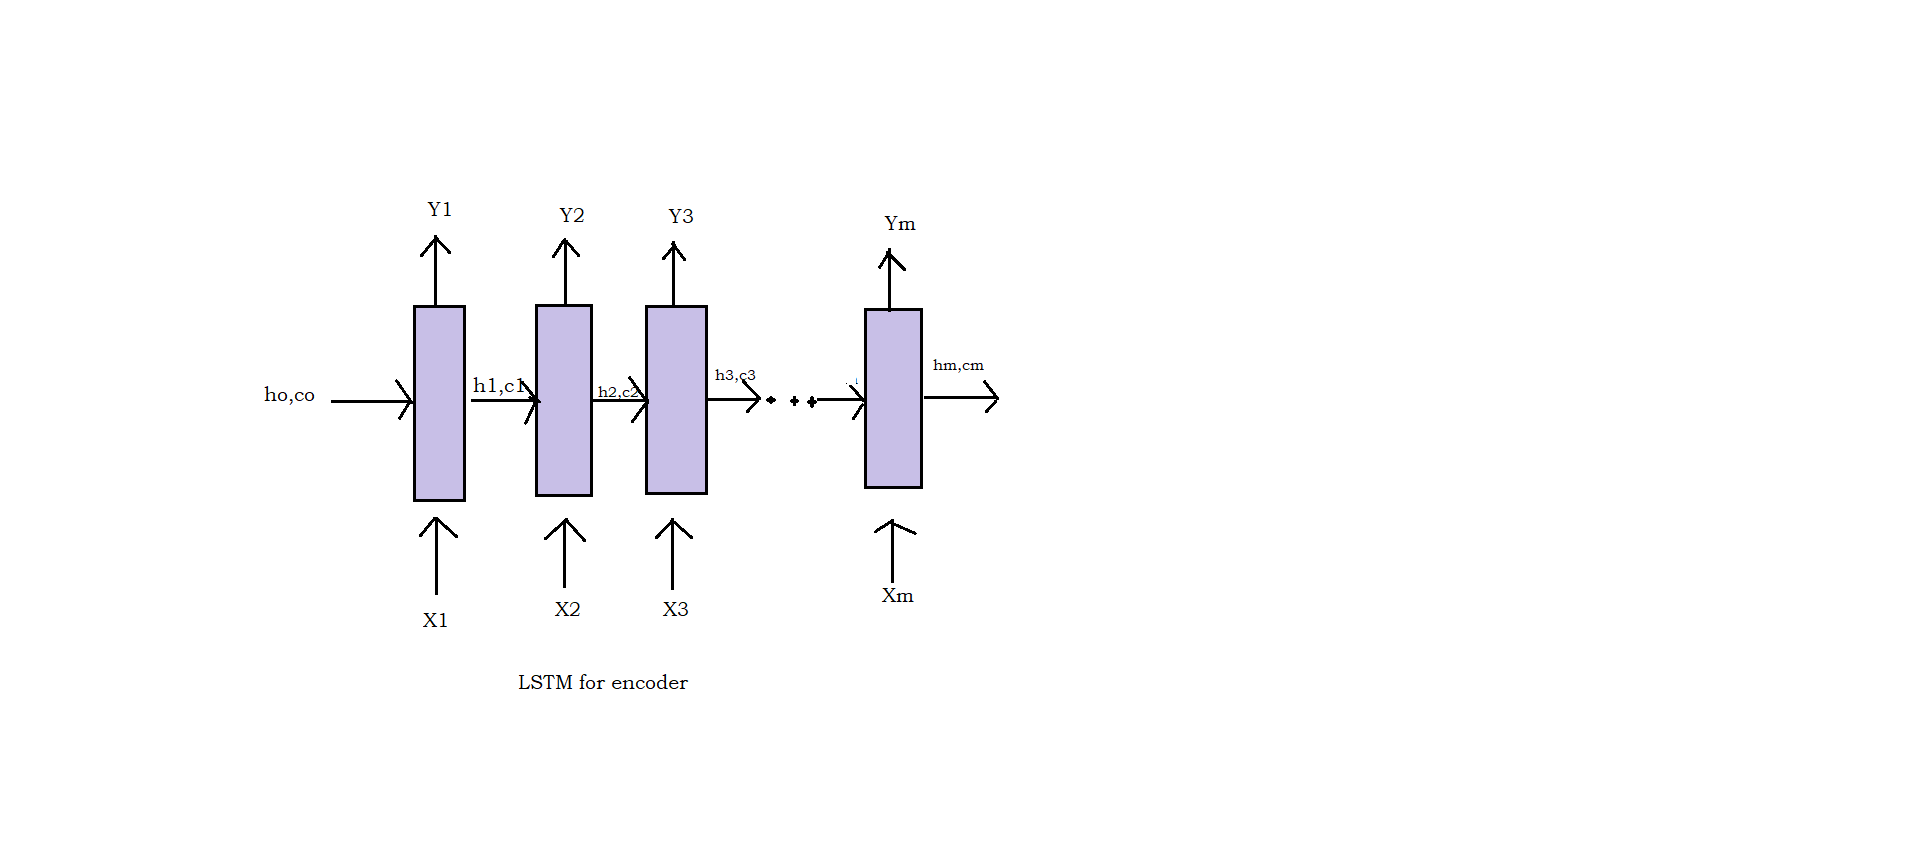
LSTM takes only one element at a time, so if the input sequence is of length m, then LSTM takes m time steps to read the entire sequence.  
•Xt is the input at time step t.  
•ht and ct are internal states at time step t of the LSTM and for GRU there is only one internal state ht.  
•Yt is the output at time step t.  

Let’s consider an example of English to Hindi translation-

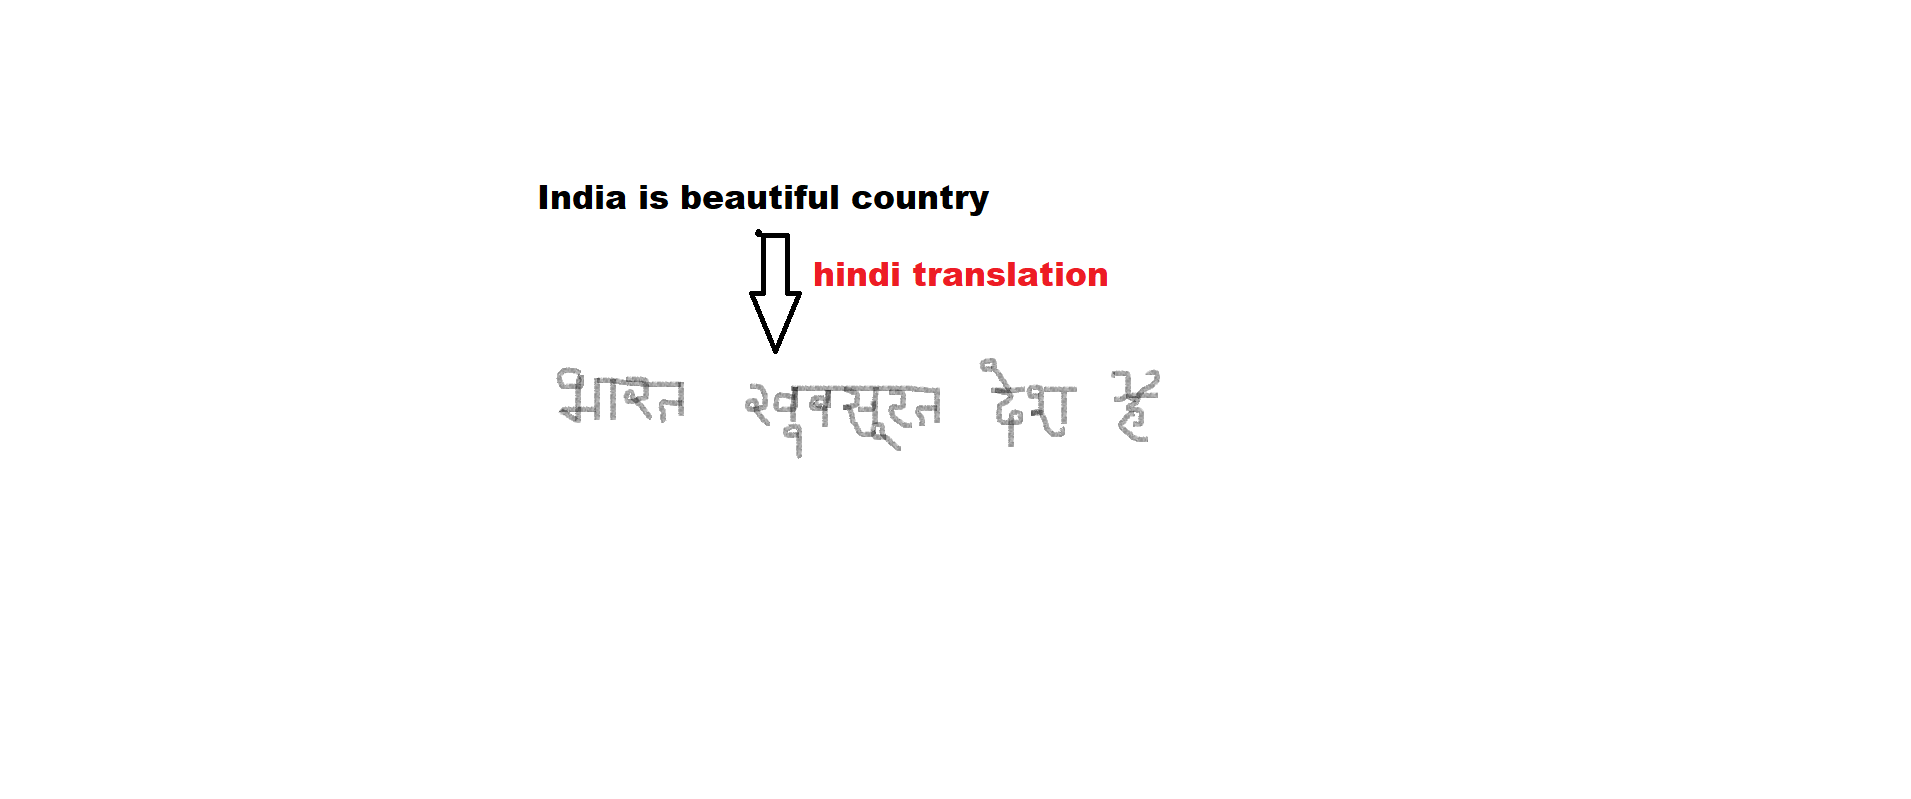

##### Inputs of Encoder Xt-

Consider the English sentence- India is beautiful country. This sequence can be thought of as a sentence containing 4 words (India, is, beautiful, country). So here

X1 =’India’

X2=’is’

X3= ‘beautiful’

X4=’country’.

Therefore LSTM will read this sequence word by word in 4-time step as follows-
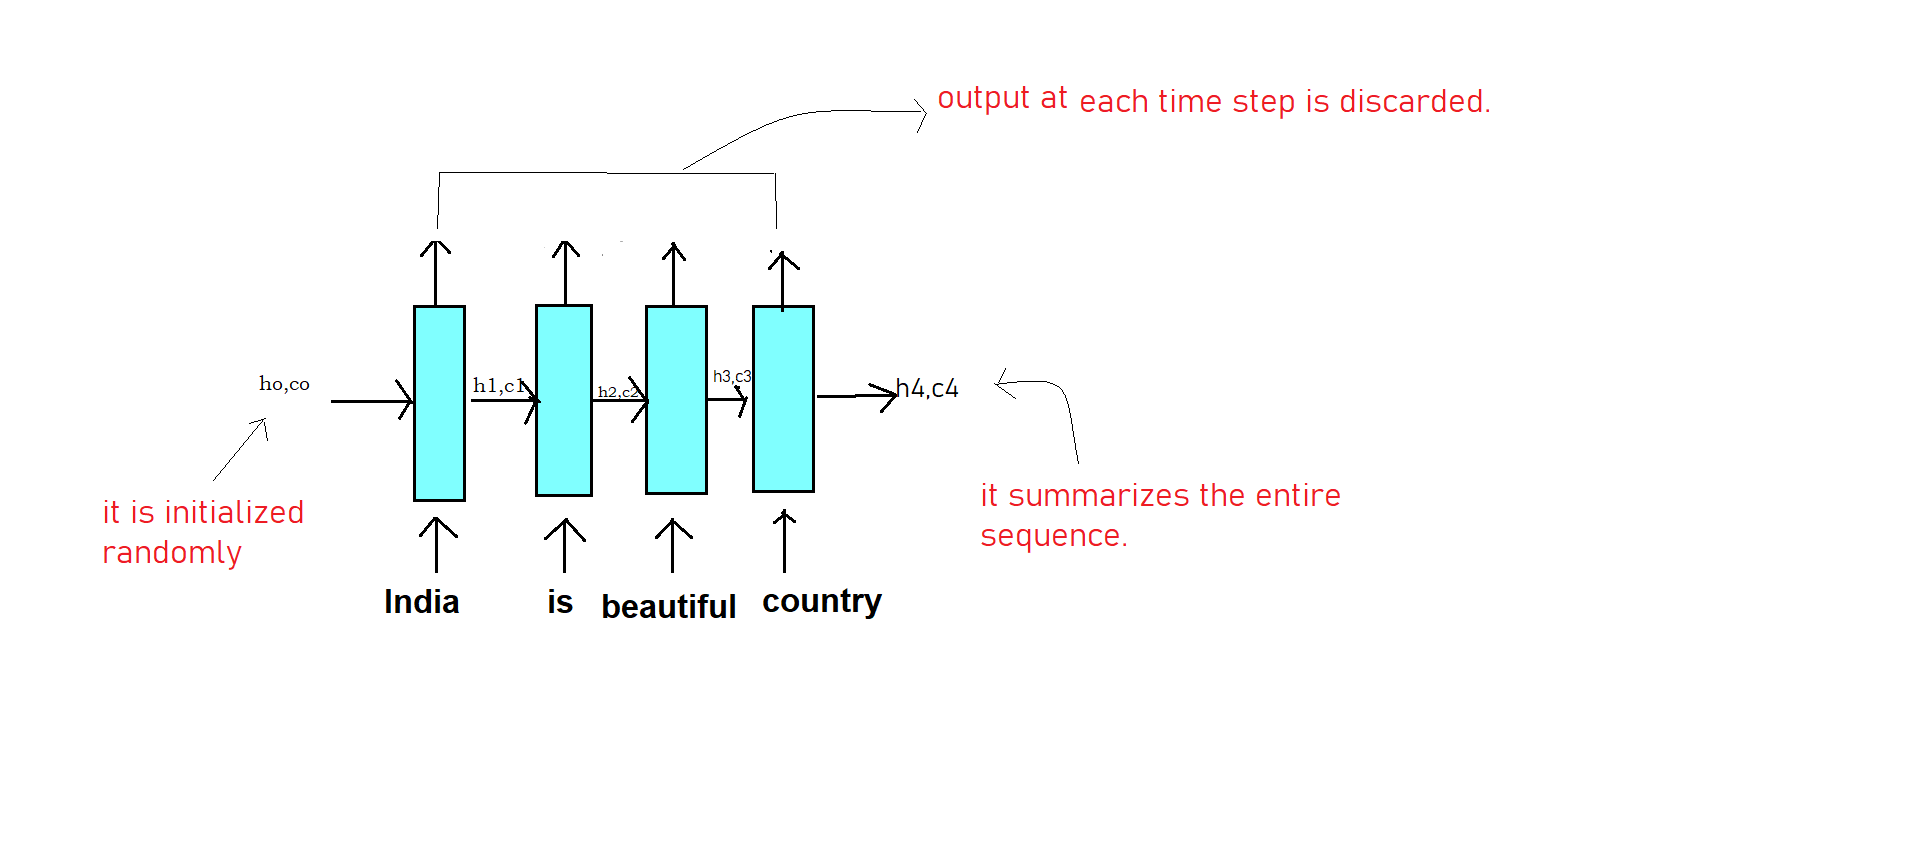
Here each Xt (each word) is represented as a vector using the word embedding, which converts each word into a vector of fixed length.

##### Now coming to internal states (ht,ct) -
•It learns what the LSTM has read until time step t. For e.g when t=2, it remembers that LSTM has read ‘India is ‘.  
•The initial states ho, co(both are vectors) is initialized randomly or with zeroes.  
•Remember the dimension of ho, co is same as the number of units in LSTM cell.  
•The final state h4,c4 contains the crux of the entire input sequence India is beautiful country.

##### The output of encoder Yt-

Yt at each time steps is the predictions of the LSTM at each time step. In machine translation problems, we generate the outputs when we have read the entire input sequence. So Yt at each time step in the encoder is of no use so we discard it.

#### Summarizing the encoder part of the model-

The encoder will read the English sentence word by word and store the final internal states (known as an intermediate vector) of the LSTM generated after the last time step and since the output will be generated once the entire sequence is read, therefore outputs (Yt) of the Encoder at each time step are discarded.

### Understanding the Decoder part of the model in the Training Phase-

The working of the decoder is different during the training and testing phase unlike the encoder part of the model which works in the same fashion in training and test phase.

Let’s understand the working of the decoder part during training phase-

Taking the running example of translating India is beautiful country to its Hindi counterpart, just like encoder, the decoder also generates the output sentence word by word.

So we want to generate the output — भारत खूबसूरत देश है

For the decoder to recognize the starting and end of the sequence, we will add START_ at the beginning of the output sequence and _END at the end of the output sequence.

So our Output sentence will be START_भारत खूबसूरत देश है _END

Let’s understand the working visually-
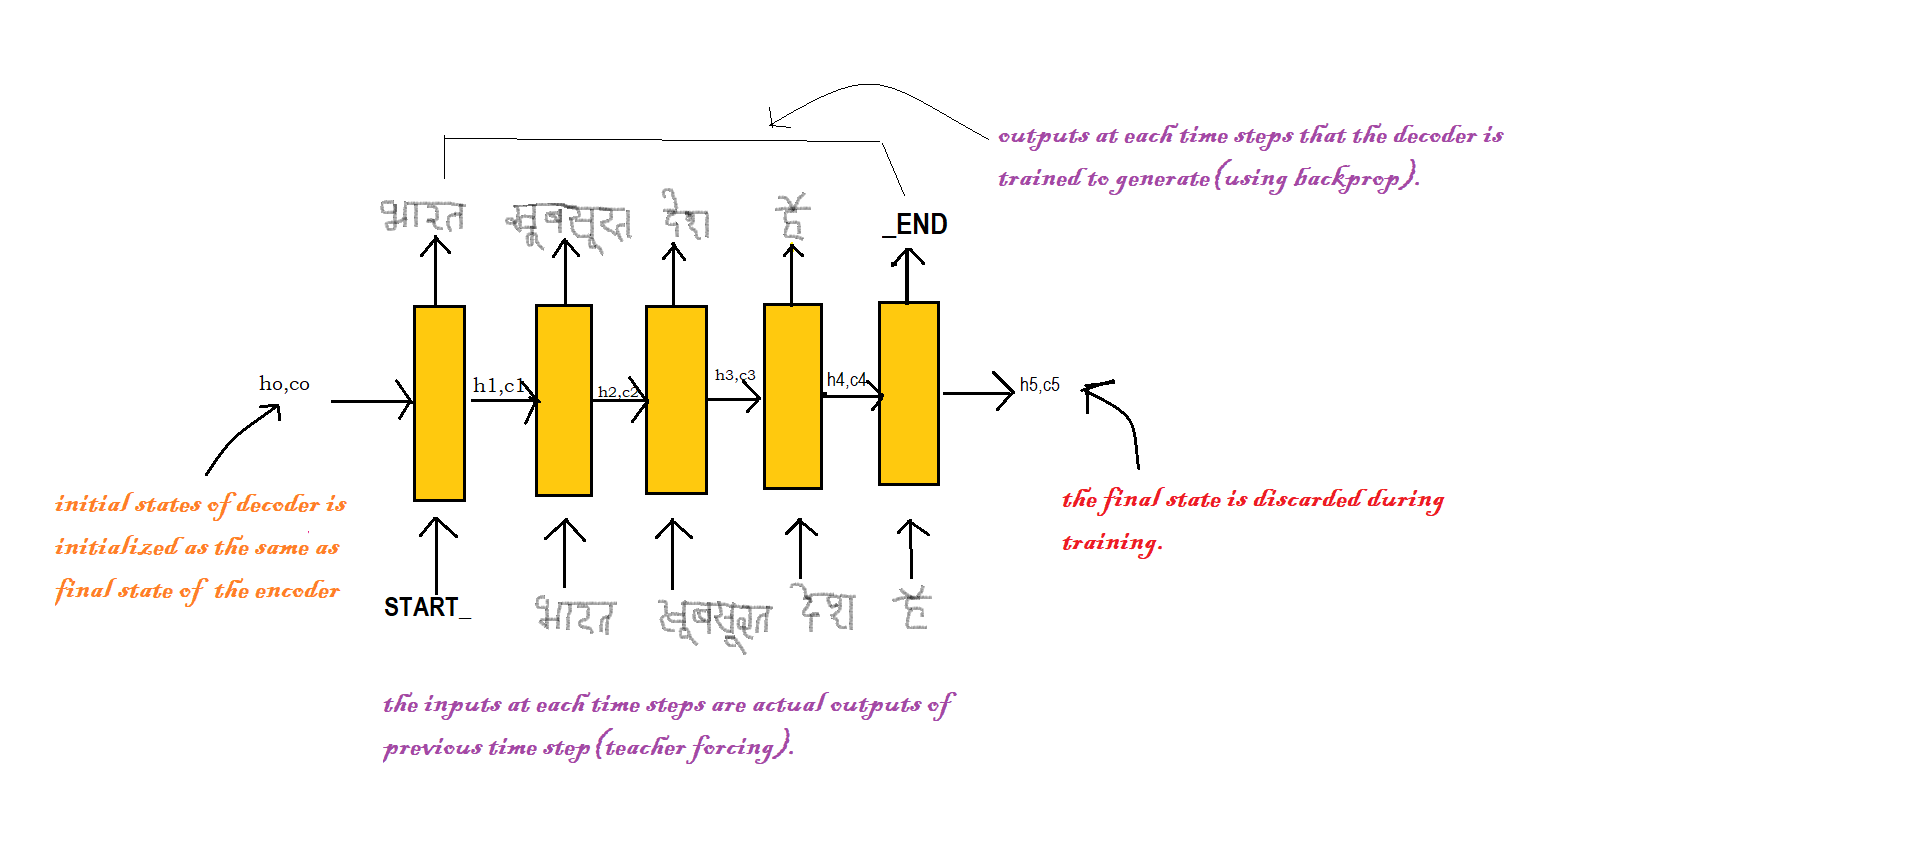

                                       Decoder LSTM at training
•The initial states (ho, co) of the decoder is set to the final states of the encoder. It can be thought of as that the decoder is trained to generate the output based on the information gathered by the encoder.  
•Firstly, we input the START_ so that the decoder starts generating the next word. And after the last word in the Hindi sentence, we make the decoder learn to predict the _END.  
•Here we use the teacher forcing technique where the input at each time step is actual output and not the predicted output from the last time step.  
•At last, the loss is calculated on the predicted outputs from each time step and the errors are backpropagated through time to update the parameters of the model.  
•The final states of the decoder are discarded as we got the output hence it is of no use.

Summarizing the encoder-decoder visually-
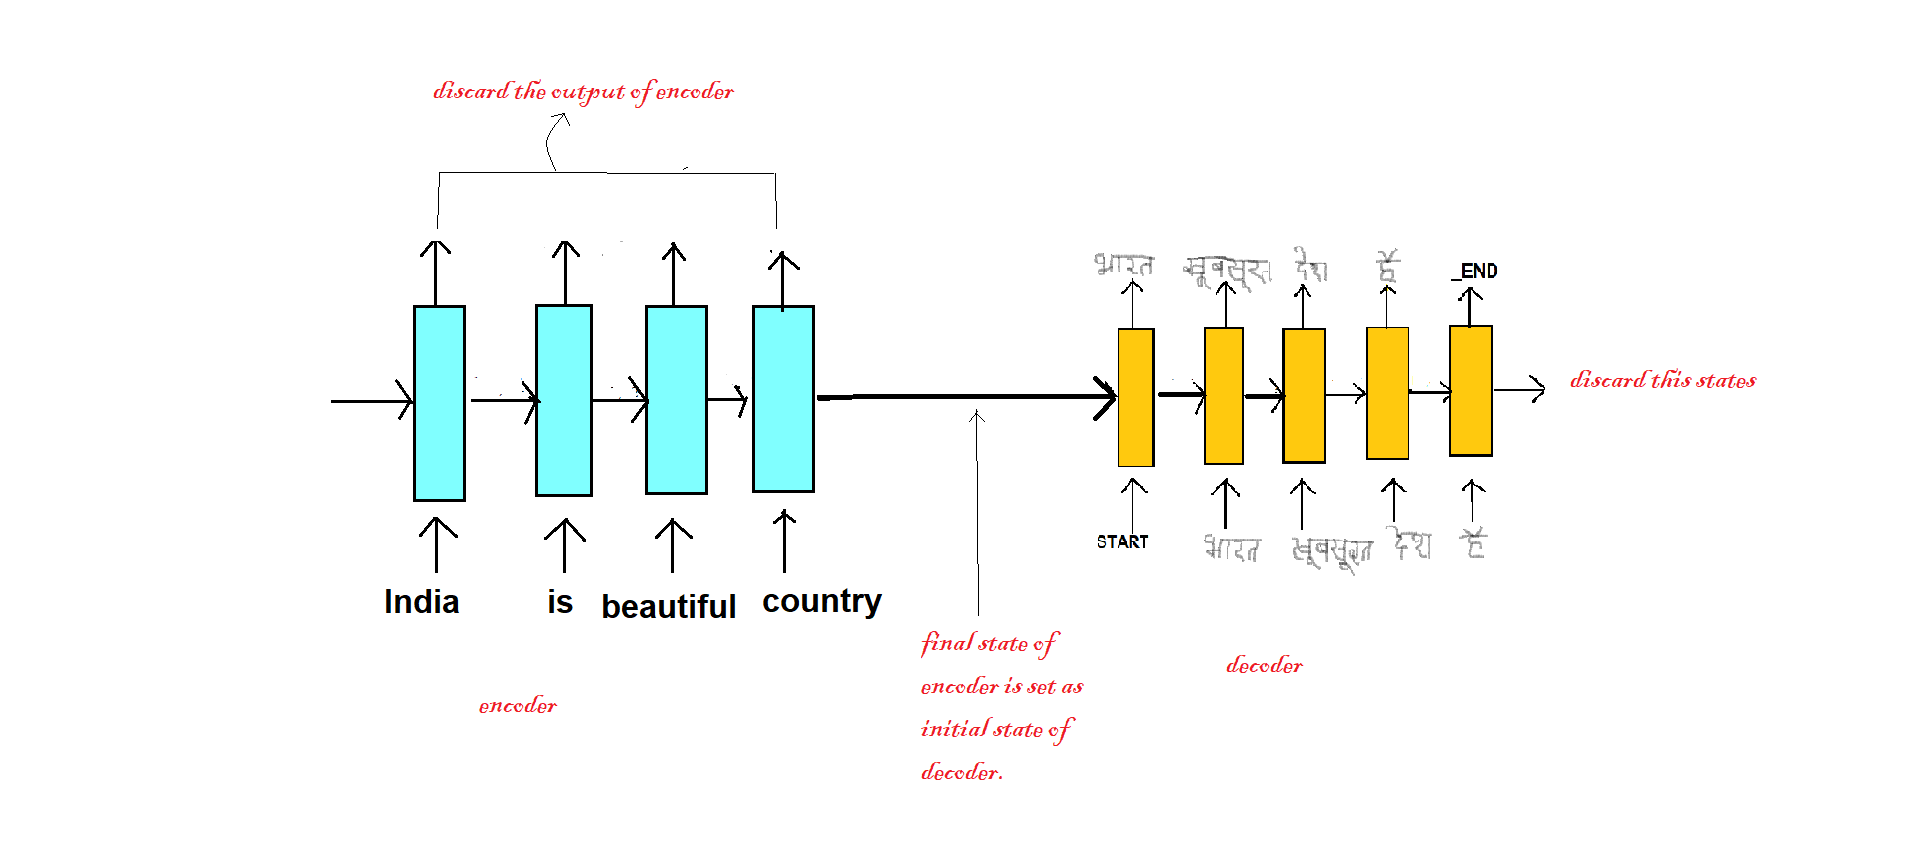

### Understanding the Decoder part of the model in Test Phase-
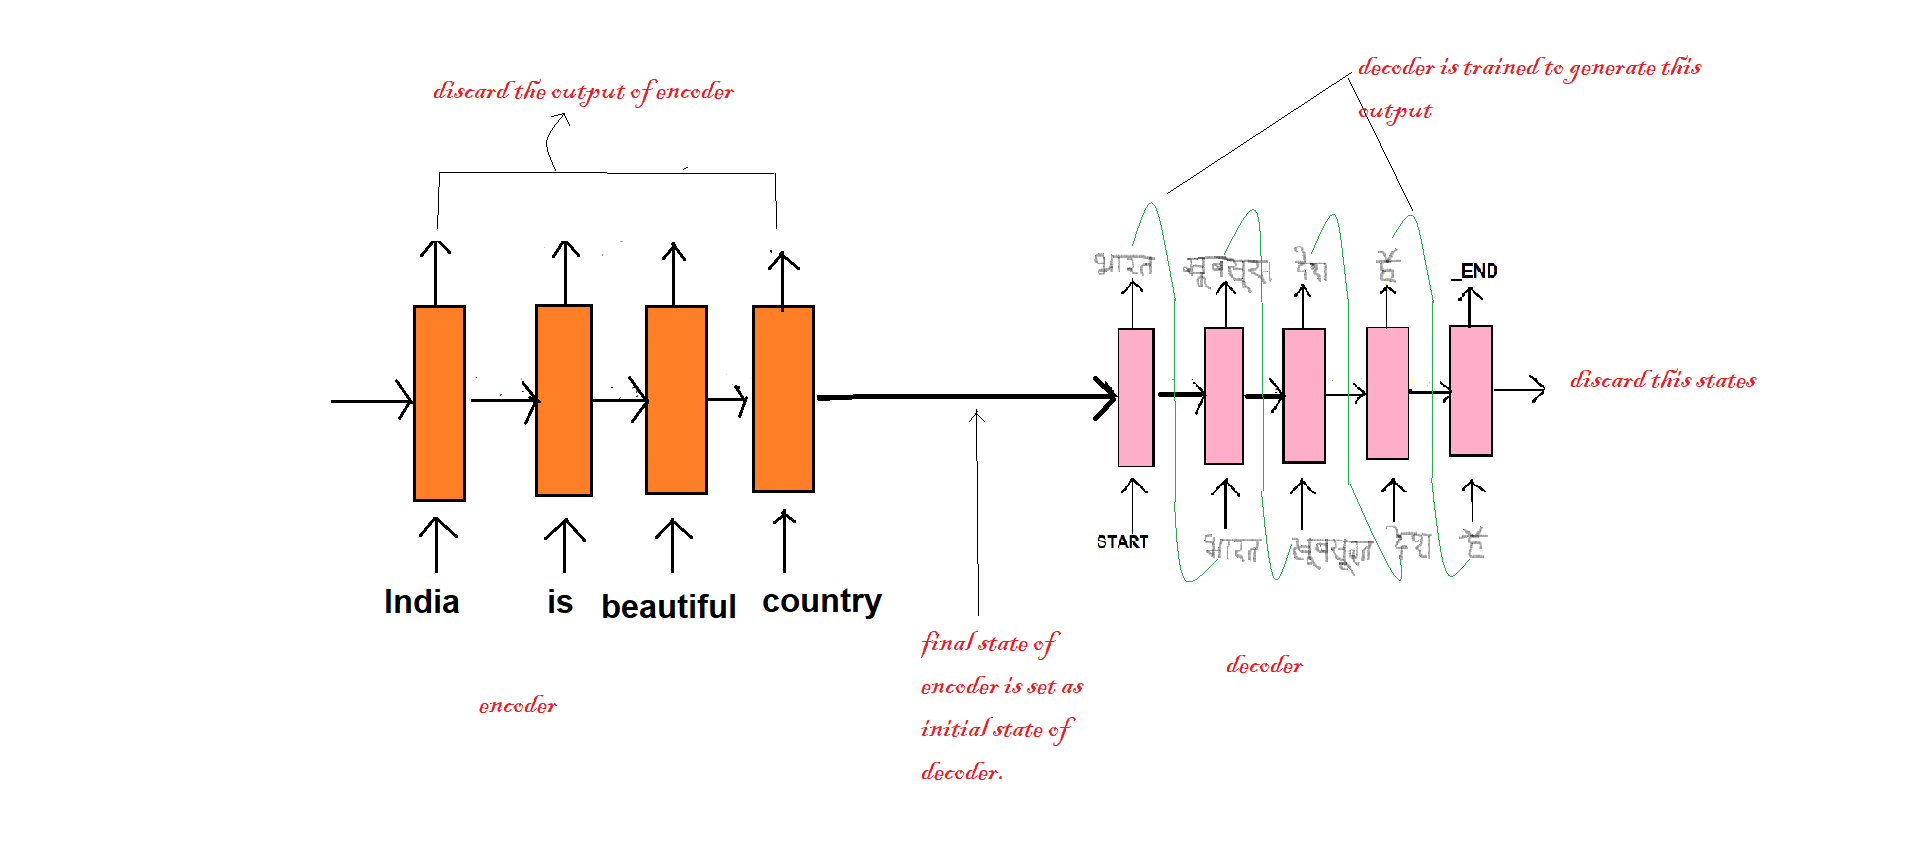
Process of the Decoder in the test period-  
•The initial states of the decoder are set to the final states of the encoder.  
•LSTM in the decoder process single word at every time step.  
•Input to the decoder always starts with the START_.  
•The internal states generated after every time step is fed as the initial states of the next time step. for e.g At t=1, the internal states produced after inputting START_ is fed as the initial states at t=2.  
•The output produced at each time step is fed as input in the next time step.  
•We get to know about the end of the sequence when the decoder predicts the END_.  

### Code -

Now as we have understood how encoder-decoder model works, let’s see the code of translating English to Hindi.  
•Load the data and see some of the data points.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import string
from string import digits
import matplotlib.pyplot as plt
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [2]:
lines=pd.read_csv("Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

In [3]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [4]:
lines=lines[lines['source']=='ted']
lines.head(10)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है
23,ted,This changed slowly,धीरे धीरे ये सब बदला
26,ted,were being produced.,उत्पन्न नहीं कि जाती थी.
30,ted,"And you can see, this LED is going to glow.","और जैसा आप देख रहे है, ये एल.ई.डी. जल उठेगी।"
32,ted,to turn on the lights or to bring him a glass ...,"लाईट जलाने के लिए या उनके लिए पानी लाने के लिए,"
35,ted,Can you imagine saying that?,क्या आप ये कल्पना कर सकते है


In [5]:
pd.isnull(lines).sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [6]:
lines=lines[~pd.isnull(lines['english_sentence'])]
lines.drop_duplicates(inplace=True)

In [7]:
lines=lines.sample(n=25000,random_state=42)
lines.shape

(25000, 3)

In [8]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [9]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

In [10]:
lines.head()

,source,english_sentence,hindi_sentence
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापि...
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END
122330,ted,and its not as hard as you think integrate cli...,START_ और जितना आपको लगता है यह उतना कठिन नहीं...


In [11]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [12]:
len(all_eng_words)

14030

In [13]:
len(all_hindi_words)

17540

In [14]:
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))

In [15]:
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापि...,11,16
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END,2,5
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END,7,8
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END,4,6
122330,ted,and its not as hard as you think integrate cli...,START_ और जितना आपको लगता है यह उतना कठिन नहीं...,16,20


In [16]:
lines[lines['length_eng_sentence']>30].shape

(0, 5)

In [17]:
lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]

In [18]:
lines.shape

(24774, 5)

In [19]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [20]:
max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])

In [21]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)+1
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(14031, 17540)

In [22]:
num_decoder_tokens += 1 #for zero padding

In [23]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [24]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [25]:
lines = shuffle(lines)
lines.head(10)

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
13878,ted,for the continent for the people and for yours...,START_ महाद्वीप का लोगों को और अपने आप के लिए ...,9,13
118799,ted,in harvesting rain,START_ वर्षा संरक्षण में। _END,3,5
101207,ted,can sell or make a profit,START_ बिक्री कर सकते हैं या मुनाफा कमा सकते ह...,6,11
87156,ted,video radio okay release the balloon,START_ चलचित्र आकाशवाणी ठीक है गुब्बारा छोड़ो ...,6,8
32877,ted,and i want to talk to you now about different ...,START_ और मै आप सबसे बात करना चाह्ती हूँ भिन्न...,13,18
83334,ted,and here we are about to board our bus,START_ और यहाँ हम अपने बस में सवार होने की तैय...,9,14
38880,ted,to me doing another one for you so here it is,START_ मुझे आपके लिये एक और करने के लिए _END,11,10
114080,ted,and this is what he got painted,START_ और एसे उन्होंने अपनी दीवार पर रोगन किया...,7,11
11949,ted,can you break your culture of silence,START_ क्या आप अपनी चुप्पी की संस्कृति को तोड़...,7,12
74643,ted,the opposite is also true,START_ उसका विपरीत भी उतना ही सच है _END,5,9


In [26]:
X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((19819,), (4955,))

In [27]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [28]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [29]:
latent_dim=300

In [30]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [31]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [32]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    4209300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    5262300     input_2[0][0]                    
____________________________________________________________________________________________

In [34]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 256
epochs = 10  # We need epochs > 100 for better accuracy

In [35]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//(batch_size),
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//(batch_size)
                   )

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
77/77 [==============================] - 680s 9s/step - loss: 3.0782 - val_loss: 3.0489
Epoch 2/10
77/77 [==============================] - 673s 9s/step - loss: 2.8106 - val_loss: 2.8577
Epoch 3/10
77/77 [==============================] - 661s 9s/step - loss: 2.6861 - val_loss: 2.7546
Epoch 4/10
77/77 [==============================] - 3235s 42s/step - loss: 2.5632 - val_loss: 2.5716
Epoch 5/10
77/77 [==============================] - 711s 9s/step - loss: 2.4709 - val_loss: 2.5874
Epoch 6/10
77/77 [==============================] - 676s 9s/step - loss: 2.3954 - val_loss: 2.6347
Epoch 7/10
77/77 [==============================] - 679s 9s/step - loss: 2.3276 - val_loss: 2.5688
Epoch 8/10
77/77 [==============================] - 686s 9s/step - loss: 2.2626 - val_loss: 2.6014
Epoch 9/10
77/77 [==============================] - 670s 9s/step - loss: 2.1980 - val_loss: 2.5705
Epoch 10/10
77/77 [==============================] - 673s 9s/step - loss: 2.1366 - val_loss: 2.6026


In [45]:
model.save_weights('nmt_weights.h5')

In [46]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [47]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [48]:
train_gen = generate_batch(X_train, y_train, batch_size = 2)
k=-1

In [49]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: and learn how to find scammers when they get email offers come in
Actual Hindi Translation:  और सीखें कि कैसे तमाम ईमेलों में असल खरीदने वालों को कैसे ढूँढा जाये । 
Predicted Hindi Translation:  और आप देख सकते हैं कि वो वो और भी भी भी भी भी भ


In [50]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: moving real fast”
Actual Hindi Translation:  जो तेजी से बढ़ रहे” 
Predicted Hindi Translation:  एक सदी के लिए 


In [51]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: harvest baby teeth
Actual Hindi Translation:  दूध के दाँतों की फसल काट लो 
Predicted Hindi Translation:  जो कि एक और दुनिया के साथ और भी भी 


In [52]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: and of course
Actual Hindi Translation:  और वाकई 
Predicted Hindi Translation:  जो कि और उनके पास और एक और भी भी भी भी 


In [53]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: is all about french soft power the british council
Actual Hindi Translation:  वह सिर्फ फ़्रांसिसी नर्म शक्ति और अंग्रेजी परिषद् के बारे में है 
Predicted Hindi Translation:  एक औरत के लिए एक ही 
